In [32]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import requests
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString

## 1. Prepare 2025 data

In [60]:
root = '/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/'
choice_data = pd.read_csv(root+'2.Joint mode and destination modeling/(1226) choice_dataset_v2.csv',dtype={'origin_county':str,'destination_county':str})
choice_data['intercept'] = 1
choice_data['origin_county'] = choice_data['origin_county'].map(lambda x:'0'+x if len(x)==4 else x)
choice_data['destination_county'] = choice_data['destination_county'].map(lambda x:'0'+x if len(x)==4 else x)
choice_data_25 = choice_data.copy(deep=True)

In [61]:
choice_data_25.head()

,origin_county,Pop_group,Trip_purpose,Time_period,destination_county,origin_region,destination_region,mode,Trip_num,auto_tt,...,Is_NYC,F_T_NYC,cost_new_NYC,auto_tt_NYC,transit_at_NYC,transit_et_NYC,transit_wt_NYC,transit_ivt_NYC,non_auto_tt_NYC,intercept
0,09001,LowIncome,Commute,Overnight,09001,CTS,CTS,biking,107,0.000000,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,09001,LowIncome,Commute,Overnight,09001,CTS,CTS,carpool,4113,19.843180,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,09001,LowIncome,Commute,Overnight,09001,CTS,CTS,driving,6295,16.828753,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,09001,LowIncome,Commute,Overnight,09001,CTS,CTS,ondemand,83,15.445783,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,09001,LowIncome,Commute,Overnight,09001,CTS,CTS,transit,336,0.000000,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Update auto travel time

In [62]:
OD_pairs = choice_data_25[['origin_county','destination_county']].drop_duplicates()
OD_pairs = OD_pairs[(OD_pairs['origin_county']=='36061-1')|(OD_pairs['destination_county']=='36061-1')]
CRZ = gpd.read_file(root+'0.Geographic Boundary/NY_NJ_counties_crz_split.shp')
Counties = gpd.read_file(root+'0.Geographic Boundary/For New Study Area/MSA_counties.shp')
Counties = pd.concat([Counties[Counties['GEOID']!='36061'],CRZ[CRZ['GEOID'].isin(['36061-1','36061-0'])]],ignore_index=True)
Counties['lng'] = Counties.geometry.centroid.x
Counties['lat'] = Counties.geometry.centroid.y
OD_pairs = pd.merge(OD_pairs,Counties[['GEOID','lng','lat']],left_on='origin_county',right_on='GEOID',how='left')
OD_pairs = pd.merge(OD_pairs,Counties[['GEOID','lng','lat']],left_on='destination_county',right_on='GEOID',how='left')

In [63]:
geometry_O = [Point(xy) for xy in zip(OD_pairs.lng_x, OD_pairs.lat_x)]
geometry_D = [Point(xy) for xy in zip(OD_pairs.lng_y, OD_pairs.lat_y)]
OD_lst = []
for i in range(len(OD_pairs)):
    OD = LineString([geometry_O[i],geometry_D[i]])
    OD_lst.append(OD)
g = gpd.GeoSeries(OD_lst)
OD_pairs = gpd.GeoDataFrame(OD_pairs,geometry=g,crs="EPSG:4326")

In [64]:
CRZ_zone = gpd.read_file(root+'0.Geographic Boundary/NYC Congestion Relief Zone (One polygon).shp')
zone_boundary = CRZ_zone.unary_union.boundary   # → one (Multi)LineString
intersection = OD_pairs.geometry.intersection(zone_boundary)
OD_pairs['lng_i'] = intersection.map(lambda p: p.x if p.geom_type == "Point" else CRZ_zone.geometry.centroid.x.values[0])
OD_pairs['lat_i'] = intersection.map(lambda p: p.y if p.geom_type == "Point" else CRZ_zone.geometry.centroid.y.values[0])

In [65]:
gdf = OD_pairs.copy()
gdf["pt_x"] = gpd.points_from_xy(gdf.lng_x, gdf.lat_x, crs="EPSG:4326")
gdf["pt_i"] = gpd.points_from_xy(gdf.lng_i, gdf.lat_i, crs="EPSG:4326")
gdf["pt_y"] = gpd.points_from_xy(gdf.lng_y, gdf.lat_y, crs="EPSG:4326")
# 2. project to a metre-based CRS (NY State Plane Long Island)
target_crs = "EPSG:3857"
pts_x = gpd.GeoSeries(gdf.pt_x).to_crs(target_crs)
pts_i = gpd.GeoSeries(gdf.pt_i).to_crs(target_crs)
pts_y = gpd.GeoSeries(gdf.pt_y).to_crs(target_crs)
# 3. vectorised distances
gdf["dist_x_i"] = pts_x.distance(pts_i)/1000
gdf["dist_i_y"] = pts_i.distance(pts_y)/1000
gdf["dist_x_y"] = pts_x.distance(pts_y)/1000

def calculate_impact_factor(record):
    if record['destination_county'] == '36061-1' and record['origin_county'] == '36061-1': # Inside CRZ
        return 1
    elif record['destination_county'] == '36061-1':
        return record['dist_i_y'] / record['dist_x_y']
    elif record['origin_county'] == '36061-1':
        return record['dist_x_i'] / record['dist_x_y']
    else:
        return None

gdf["factor"] = gdf.apply(calculate_impact_factor,axis=1)

In [66]:
gdf.iloc[17:19][['origin_county','destination_county','pt_x','pt_i','pt_y','dist_x_i','dist_i_y','dist_x_y','factor']]

,origin_county,destination_county,pt_x,pt_i,pt_y,dist_x_i,dist_i_y,dist_x_y,factor
17,36027,36061-1,POINT (-73.74286 41.76516),POINT (-73.98489 40.77085),POINT (-73.99476 40.73029),149.710782,6.059668,155.770445,0.038901
18,36047,36061-1,POINT (-73.95023 40.63437),POINT (-73.98508 40.70944),POINT (-73.99476 40.73029),11.682344,3.246793,14.929137,0.217480


In [67]:
choice_data_25 = pd.merge(choice_data_25,gdf[['origin_county','destination_county','factor']],
                          on=['origin_county','destination_county'],how='left')
choice_data_25['factor'] = choice_data_25['factor'].fillna(0)

In [68]:
def update_auto_tt(record):
    if record['mode'] not in ['carpool','driving','ondemand']:
        return record['auto_tt']
    else:
        return record['auto_tt']*(1-record['factor']) + record['auto_tt']*record['factor']*(1-0.15)

In [69]:
choice_data_25['auto_tt'] = choice_data_25.apply(update_auto_tt,axis=1)

In [70]:
condition1 = choice_data_25['mode'].isin(['carpool','driving','ondemand'])
condition2 = (choice_data_25['destination_county']=='36061-1')&(choice_data_25['origin_county']=='36061-0')
choice_data_25[condition1&condition2]['auto_tt'].mean()

np.float64(15.931964889251566)

In [71]:
condition1 = choice_data['mode'].isin(['carpool','driving','ondemand'])
condition2 = (choice_data['destination_county']=='36061-1')&(choice_data['origin_county']=='36061-0')
choice_data[condition1&condition2]['auto_tt'].mean()

np.float64(17.042187169932326)

In [72]:
(choice_data_25[condition1&condition2]['auto_tt'].mean()-choice_data[condition1&condition2]['auto_tt'].mean())/choice_data[condition1&condition2]['auto_tt'].mean()

np.float64(-0.06514552795427192)

### Update transit travel time

In [73]:
transit_matrix_peak = pd.read_csv(root + '1.Replica Data Processing/Transit_details_2025_June_5th_9AM.csv')
OD_matrix = pd.read_csv(root+'1.Replica Data Processing/OD_matrix_in_OTP.csv',dtype={'origin_bgrp':'str','destination_bgrp':'str','origin_county':'str','destination_county':'str'})
transit_matrix_peak[['origin_bgrp','destination_bgrp','origin_county','destination_county']] = OD_matrix[['origin_bgrp','destination_bgrp','origin_county','destination_county']]
transit_matrix_peak[['transit_at','transit_et','transit_wt','transit_ivt']]/=60

In [74]:
data_2020 = pd.read_csv(root+'1.Replica Data Processing/(1226) data_2020.csv',dtype={'origin_bgrp':str,'destination_bgrp':str})
check = data_2020[data_2020['Pro_PUBLIC_TRANSIT']>0][['origin_bgrp', 'destination_bgrp', 'Pop_group', 'Trip_purpose',
       'Time_period', 'Trip_num','Access_time','Egress_time', 'In_vehicle_time', 'Num_transfer','Pro_PUBLIC_TRANSIT']]

In [75]:
check_peak = pd.merge(check,transit_matrix_peak[transit_matrix_peak['cost']>0],on=['origin_bgrp','destination_bgrp'])
check_peak['Total_Replica'] = check_peak['Access_time']+check_peak['Egress_time']+check_peak['In_vehicle_time']
check_peak['Total_OTP'] = check_peak['transit_at']+check_peak['transit_et']+check_peak['transit_ivt']+check_peak['transit_wt']

In [76]:
def wavg(group, value_col, weight_col):
    """Return the weighted average of `value_col` using `weight_col`."""
    v = group[value_col]
    w = group[weight_col]
    return np.average(v, weights=w)

In [77]:
transit_agg = (check_peak
       .groupby(['origin_county', 'destination_county','Pop_group','Trip_purpose','Time_period'])
       .apply(lambda g: pd.Series({
           'OTP_transit_at': wavg(g, 'transit_at', 'Trip_num'),
           'OTP_transit_et': wavg(g, 'transit_et', 'Trip_num'),
           'OTP_transit_ivt': wavg(g, 'transit_ivt', 'Trip_num'),
           'OTP_transit_wt': wavg(g, 'transit_wt', 'Trip_num'),
           'OTP_transit_nt': wavg(g, 'transit_nt', 'Trip_num'),
           'OTP_transit_cost': wavg(g, 'cost', 'Trip_num'),
           'total_trips':      g['Trip_num'].sum()        # optional
       }))
       .reset_index())

transit_agg_dict = dict(tuple(transit_agg.groupby(['origin_county', 'destination_county','Pop_group','Trip_purpose','Time_period'])))

In [78]:
wt_factor = (check_peak['transit_wt']/check_peak[['transit_at','transit_ivt','transit_et']].sum(axis=1)).mean() # avg. waiting time / total travel time
print(wt_factor)

def OPT_transit_time_cost(record):
    # Only for transit
    if record['mode']=='transit':
        try:
            data = transit_agg_dict[(record['origin_county'],record['destination_county'],record['Pop_group'],record['Trip_purpose'],record['Time_period'])]
            values = data[['OTP_transit_at','OTP_transit_et','OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt','OTP_transit_cost']].values[0]
            #values[2] = min(values[2],30)
            return pd.Series(values)
        except:
            wt = (record['transit_at']+record['transit_et']+record['transit_ivt'])*wt_factor
            return pd.Series([record['transit_at'],record['transit_et'],wt,record['transit_ivt'],record['transit_nt'],0])
    else:
        return pd.Series([0,0,0,0,0,0])

def get_new_cost(record):
    if record['Pop_group']=='Senior':
        factor = 0.5
    else:
        factor = 1
    if record['mode']=='transit':
        if record['OTP_transit_cost']>0:
            return record['OTP_transit_cost'] * factor
        else:
            REGION_MAP = {"Manhattan": "NYC"} 
            FARE = {"NJS": 2.75, "NYS": 1.5, "NYC": 2.75, 'CTS': 1.5, 'PAS': 1.5}
            o = REGION_MAP.get(record["origin_region"], record["origin_region"])
            d = REGION_MAP.get(record["destination_region"], record["destination_region"])
            fare = sum([FARE[x] for x in set([o,d])])
            return fare * factor
    else:
        return record['cost']

0.1413315102131193


In [79]:
choice_data_25[['OTP_transit_at','OTP_transit_et','OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt','OTP_transit_cost']] = choice_data_25.apply(OPT_transit_time_cost,axis=1)
choice_data_25['cost_new'] = choice_data_25.apply(get_new_cost,axis=1)

In [80]:
ratios = (choice_data_25[['OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt']] / \
choice_data[['OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt']]).fillna(0).values

choice_data_25[['transit_wt','transit_ivt','transit_nt']] *= ratios

### Consider the fluctation of fuel price

FRED Economic Data (NY-Newark-Jersey City): https://fred.stlouisfed.org/series/APUS12A74714

In [81]:
fuel_price_2023_Q2 = 3.47
fuel_price_2024_Q2 = 3.47
fuel_price_2025_Q2 = 2.99
pct_change = (fuel_price_2025_Q2 - fuel_price_2023_Q2)/fuel_price_2023_Q2

In [82]:
def reduce_fuel_price(record):
    mode_mask = record['mode'] == 'driving'
    region_MH = (record['destination_region']=='Manhattan')|(record['origin_region']=='Manhattan')
    region_NYC = (record['destination_region']=='NYC')|(record['origin_region']=='NYC')
    if mode_mask and region_MH:
        return (record['cost_new']-6.76) * (1+pct_change) + 6.76
    elif mode_mask and region_NYC:
        return (record['cost_new']-1.87) * (1+pct_change) + 1.87
    elif mode_mask:
        return (record['cost_new']) * (1+pct_change)
    else:
        return record['cost_new']

choice_data_25['cost_new'] = choice_data_25.apply(reduce_fuel_price,axis=1)

In [83]:
assert choice_data_25['cost_new'].min() >= 0

### Add congestion toll

In [84]:
def add_toll(record):
    region_condition = record['destination_county']=='36061-1' and record['origin_county']!='36061-1'
    if region_condition and record['Time_period']=='Overnight' and record['mode'] in ['driving','ondemand']:
        return record['cost_new'] + 2.25
    elif region_condition and record['Time_period']=='Overnight' and record['mode'] in ['carpool']:
        return record['cost_new'] + 2.25/2
    elif region_condition and record['Time_period']=='Peak' and record['mode'] in ['driving','ondemand']:
        return record['cost_new'] + 9.00
    elif region_condition and record['Time_period']=='Peak' and record['mode'] in ['carpool']:
        return record['cost_new'] + 9.00/2
    else:
        return record['cost_new']

In [85]:
choice_data_25['cost_new'] = choice_data_25.apply(add_toll,axis=1)

In [86]:
choice_data_25['From_NYC'] = choice_data_25['origin_region'].isin(['NYC','Manhattan']).astype(int)

for column in ['cost_new_NYC','auto_tt_NYC','transit_at_NYC','transit_at_NYC','transit_et_NYC','transit_wt_NYC','transit_ivt_NYC','non_auto_tt_NYC']:
    choice_data_25[column] = choice_data_25[column[:-4]] * choice_data_25['From_NYC']

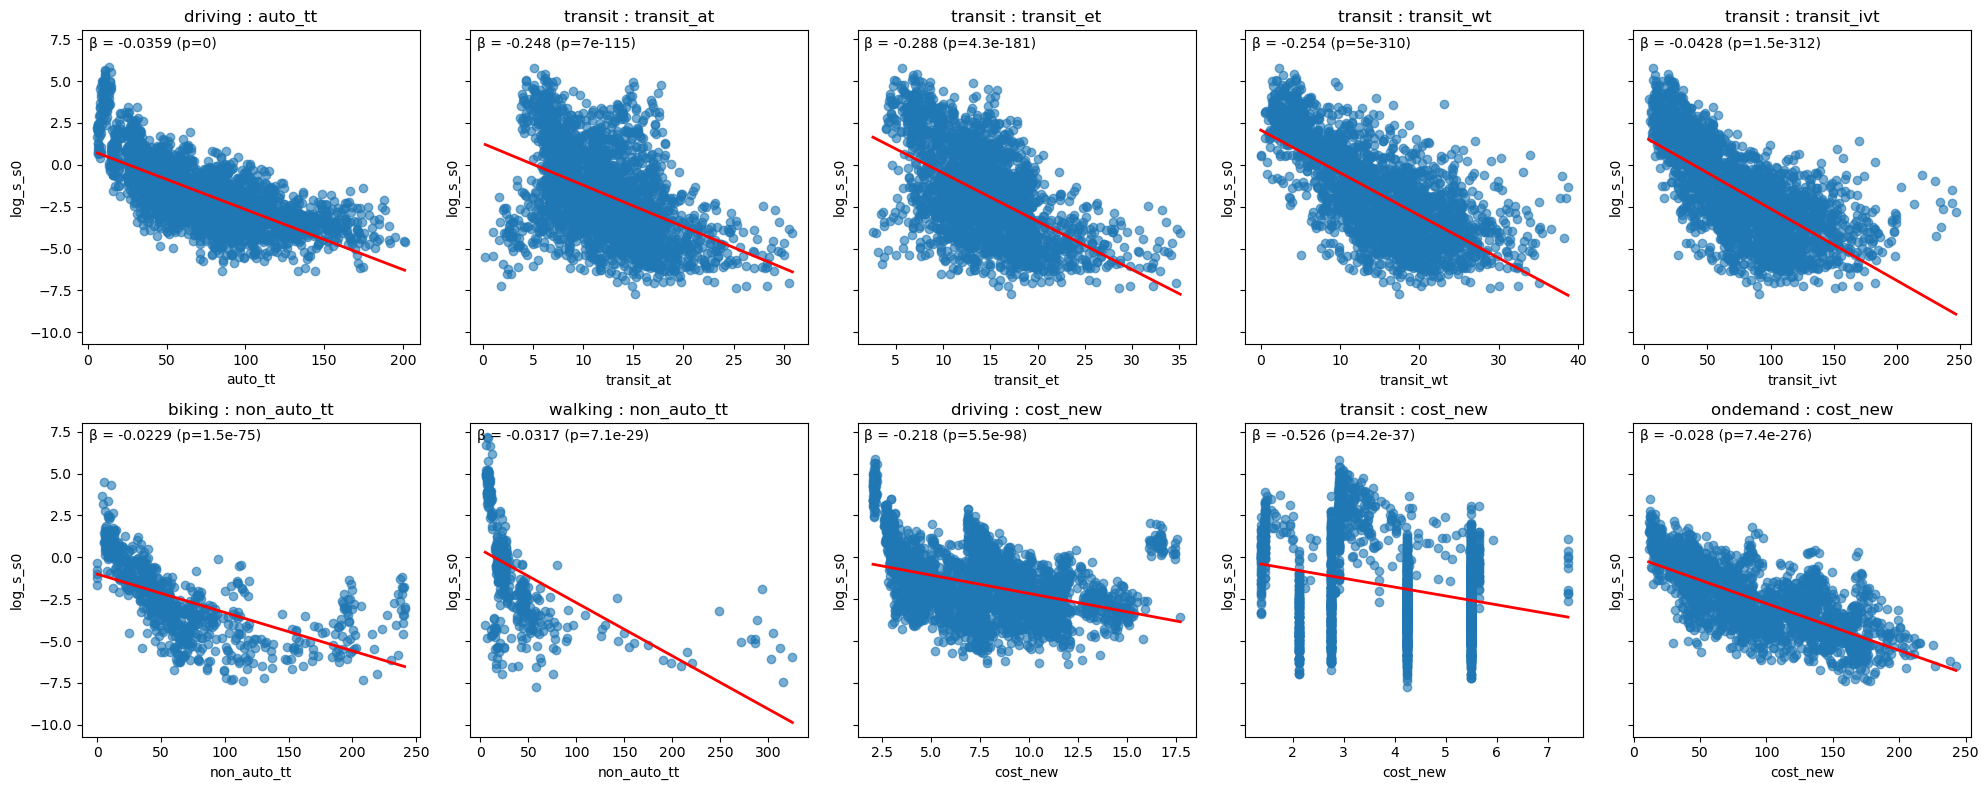

In [87]:
import statsmodels.api as sm
panels = [
    ('driving',   'auto_tt'),
    ('transit',   'transit_at'),
    ('transit',   'transit_et'),
    ('transit',   'transit_wt'),
    ('transit',   'transit_ivt'),
    ('biking',    'non_auto_tt'),
    ('walking',   'non_auto_tt'),
    ('driving', 'cost_new'),
    ('transit', 'cost_new'),
    ('ondemand', 'cost_new'),
]
yvar = 'log_s_s0'
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for ax, (mode, xvar) in zip(axes, panels):
    df = choice_data_25.loc[(choice_data_25['mode'] == mode)&(choice_data_25['From_NYC'] == 1), [xvar, yvar]].dropna()
    if df.shape[0] < 3:
        ax.set_title(f"{mode} : {xvar} (n<3)")
        ax.axis('off')
        continue
    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()
    X = sm.add_constant(x)  # adds intercept
    model = sm.OLS(y, X).fit()
    a, b = model.params[0], model.params[1]
    r2 = model.rsquared
    n = df.shape[0]
    ax.scatter(x, y, alpha=0.6)
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yline = a + b * xline
    ax.plot(xline, yline, linewidth=2, color='red')
    ax.set_title(f"{mode} : {xvar}")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.text(
        0.02, 0.98,
        f"β = {b:.3g} (p={model.pvalues[1]:.2g})\n",
        transform=ax.transAxes,
        va='top',
        ha='left'
    )
plt.tight_layout()
plt.show()

In [88]:
choice_data_25.to_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/3.Model Calibration/(1226) choice_dataset_2025.csv',index=False)